# Задача 2. Обнаружение болезни паркинсона с помощью XGBoost

## Условия

Нужно предсказать наличие болезни Паркинсона по медицинским (голосовым) измерениям из датасета UCI с помощью модели XGBoost (XGBClassifier, scikit-learn API) и применить нормализацию признаков (например, StandardScaler от sklearn).

Выборки делить в соотношении 80% обучающая, 20% - тестовая.
Получить точность более 95%.

Датасет: https://storage.yandexcloud.net/academy.ai/practica/parkinsons.data.

Описание признаков и меток датасета: https://storage.yandexcloud.net/academy.ai/practica/parkinsons.names

## Решение

### Импорты

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, recall_score
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

### Изучаем датасет

In [2]:
# Скачиваем датасет
!wget https://storage.yandexcloud.net/academy.ai/practica/parkinsons.data

--2025-07-31 19:42:03--  https://storage.yandexcloud.net/academy.ai/practica/parkinsons.data
Resolving storage.yandexcloud.net (storage.yandexcloud.net)... 213.180.193.243, 2a02:6b8::1d9
Connecting to storage.yandexcloud.net (storage.yandexcloud.net)|213.180.193.243|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 40697 (40K) [application/x-www-form-urlencoded]
Saving to: ‘parkinsons.data.2’

parkinsons.data.2   100%[===================>]  39.74K  --.-KB/s    in 0.1s    

2025-07-31 19:42:04 (317 KB/s) - ‘parkinsons.data.2’ saved [40697/40697]



In [3]:
# Открываем скачанный файл
df = pd.read_csv("./parkinsons.data")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 195 entries, 0 to 194
Data columns (total 24 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   name              195 non-null    object 
 1   MDVP:Fo(Hz)       195 non-null    float64
 2   MDVP:Fhi(Hz)      195 non-null    float64
 3   MDVP:Flo(Hz)      195 non-null    float64
 4   MDVP:Jitter(%)    195 non-null    float64
 5   MDVP:Jitter(Abs)  195 non-null    float64
 6   MDVP:RAP          195 non-null    float64
 7   MDVP:PPQ          195 non-null    float64
 8   Jitter:DDP        195 non-null    float64
 9   MDVP:Shimmer      195 non-null    float64
 10  MDVP:Shimmer(dB)  195 non-null    float64
 11  Shimmer:APQ3      195 non-null    float64
 12  Shimmer:APQ5      195 non-null    float64
 13  MDVP:APQ          195 non-null    float64
 14  Shimmer:DDA       195 non-null    float64
 15  NHR               195 non-null    float64
 16  HNR               195 non-null    float64
 1

In [4]:
# Изучаем первые 5 строк
df.head()

,name,MDVP:Fo(Hz),MDVP:Fhi(Hz),MDVP:Flo(Hz),MDVP:Jitter(%),MDVP:Jitter(Abs),MDVP:RAP,MDVP:PPQ,Jitter:DDP,MDVP:Shimmer,...,Shimmer:DDA,NHR,HNR,status,RPDE,DFA,spread1,spread2,D2,PPE
0,phon_R01_S01_1,119.992,157.302,74.997,0.00784,0.00007,0.00370,0.00554,0.01109,0.04374,...,0.06545,0.02211,21.033,1,0.414783,0.815285,-4.813031,0.266482,2.301442,0.284654
1,phon_R01_S01_2,122.400,148.650,113.819,0.00968,0.00008,0.00465,0.00696,0.01394,0.06134,...,0.09403,0.01929,19.085,1,0.458359,0.819521,-4.075192,0.335590,2.486855,0.368674
2,phon_R01_S01_3,116.682,131.111,111.555,0.01050,0.00009,0.00544,0.00781,0.01633,0.05233,...,0.08270,0.01309,20.651,1,0.429895,0.825288,-4.443179,0.311173,2.342259,0.332634
3,phon_R01_S01_4,116.676,137.871,111.366,0.00997,0.00009,0.00502,0.00698,0.01505,0.05492,...,0.08771,0.01353,20.644,1,0.434969,0.819235,-4.117501,0.334147,2.405554,0.368975
4,phon_R01_S01_5,116.014,141.781,110.655,0.01284,0.00011,0.00655,0.00908,0.01966,0.06425,...,0.10470,0.01767,19.649,1,0.417356,0.823484,-3.747787,0.234513,2.332180,0.410335


In [5]:
# Изучаем количество уникальных меток и их соотношение
df.status.value_counts()

,count
status,
1,147
0,48


## Подготавливаем датасет

In [6]:
X = df.drop(['name', 'status'], axis=1)  # Удаляем ненужный id/имя и целевую переменную
y = df['status']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [7]:
# Нормализуем данные
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [8]:
# Приводим к DataFrame
X_train_scaled = pd.DataFrame(
    X_train_scaled,
    columns=X_train.columns,
    index=X_train.index
)

# Обрезаем выбросы по IQR для каждого признака
for col in X_train_scaled.columns:
    q1 = X_train_scaled[col].quantile(0.25)
    q3 = X_train_scaled[col].quantile(0.75)
    iqr = q3 - q1
    lower = q1 - 1.5 * iqr
    upper = q3 + 1.5 * iqr
    X_train_scaled[col] = X_train_scaled[col].clip(lower, upper)

In [9]:
# Разбиваем train на tr/val (80/20 от train)
X_tr, X_val, y_tr, y_val = train_test_split(X_train_scaled, y_train, test_size=0.14, random_state=42, stratify=y_train)

## Обучаем модель

In [10]:
# Создаем модель
model = XGBClassifier(eval_metric='logloss', random_state=42, early_stopping_rounds=20)

In [11]:
model = XGBClassifier(
    n_estimators=250,
    learning_rate=0.2,
    max_depth=3,
    subsample=0.85,
    colsample_bytree=0.9,
    reg_lambda=3,
    random_state=42
)

In [12]:
model = XGBClassifier(
    n_estimators=250,
    learning_rate=0.2,
    max_depth=4,
    subsample=0.9,
    gamma=0.1,
    reg_lambda=3,
    random_state=42
)

Точность на тестовой выборке: 0.949
Чувствительность на тестовой выборке: 0.966


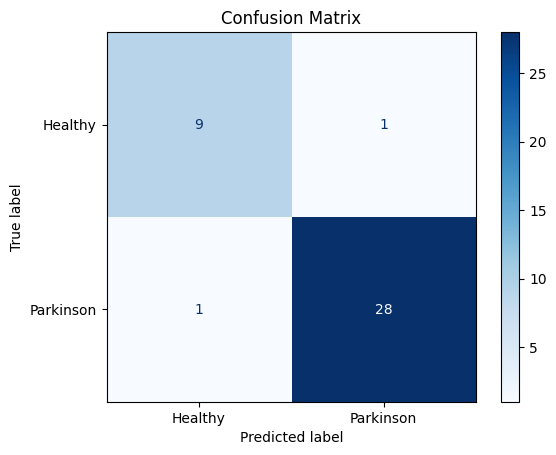

In [ ]:
model.fit(
    X_tr, y_tr,
    eval_set=[(X_val, y_val)],
    verbose=False
)

y_pred = model.predict(X_test_scaled)
acc = accuracy_score(y_test, y_pred)
rec = recall_score(y_test, y_pred)

print(f"Точность на тестовой выборке: {acc:.3f}")
print(f"Чувствительность на тестовой выборке: {rec:.3f}")

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Healthy','Parkinson'])
disp.plot(cmap='Blues')
plt.title("Confusion Matrix")
plt.show()

Пытаемся достичь 95%

In [14]:
from sklearn.decomposition import PCA
from imblearn.over_sampling import SMOTE

# Загружаем и подготавливаем данные заново для честности
df = pd.read_csv("./parkinsons.data")
X = df.drop(['name', 'status'], axis=1)
y = df['status']

X = df.drop(['name', 'status'], axis=1)
y = df['status']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Понижаем размерность
pca = PCA(n_components=0.95, random_state=42)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

# Балансируем классы
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_pca, y_train)

# Финальный подбор гиперпараметров на PCA-данных
model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)

param_grid = {
    'max_depth': [3, 4, 5],
    'learning_rate': [0.1, 0.2, 0.3],
    'n_estimators': [200, 250, 300],
    'gamma': [0, 0.1, 0.2],
    'subsample': [0.8, 0.9, 1.0]
}

grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1, verbose=1)
grid_search.fit(X_train_resampled, y_train_resampled)
best_model = grid_search.best_estimator_

y_pred = best_model.predict(X_test_pca)
accuracy = accuracy_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)

print(f"\nЛучшие параметры для PCA-данных: {grid_search.best_params_}")
print(f"Точность модели после финальной настройки: {accuracy * 100:.2f}%")
print(f"Чувствительность модели после финальной настройки: {recall * 100:.2f}%")

Fitting 5 folds for each of 243 candidates, totalling 1215 fits

Лучшие параметры для PCA-данных: {'gamma': 0, 'learning_rate': 0.3, 'max_depth': 4, 'n_estimators': 200, 'subsample': 0.9}
Точность модели после финальной настройки: 97.44%
Чувствительность модели после финальной настройки: 96.55%


## Визуализируем матрицу ошибок

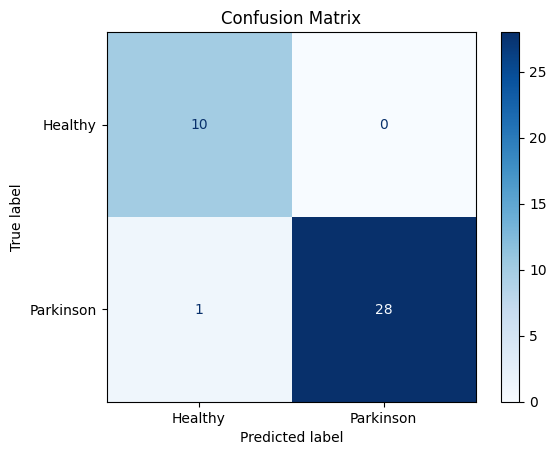

In [15]:
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Healthy','Parkinson'])
disp.plot(cmap='Blues')
plt.title("Confusion Matrix")
plt.show()